### K-meansスクラッチ

K-meansのクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


以下に雛形を用意してあります。このScratchKMeansクラスにコードを書き加えていってください。

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import statistics
from scipy import stats
import collections
import random

In [5]:
class ScratchKMeans():
    """
    K-meansのスクラッチ実装

    Parameters
    ----------
    n_clusters : int
      クラスタ数
    n_init : int
      中心点の初期値を何回変えて計算するか
    max_iter : int
      1回の計算で最大何イテレーションするか
    tol : float
      イテレーションを終了する基準となる中心点と重心の許容誤差
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, n_clusters, n_init, max_iter, tol, verbose=False):
        # ハイパーパラメータを属性として記録
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.center_log = []
        self.sse_log = []
        
    def fit(self, X):
        """
        K-meansによるクラスタリングを計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        """
        n_samples = len(X)
        self.center_log = []
        
        for l in range(self.n_init):
            idx = np.random.randint(0,n_samples,self.n_clusters)    #ランダムな行インデックスの生成
            center_n = X[idx,:] # n個のクラスタ中心点の初期値を抽出
            
            for i in range(self.max_iter):
                clusters = self.wariate(X,center_n) #クラスタの割当
                next_center_n = self.center_move(X,center_n,clusters) # 新たな重心位置を中心とする
                gosa = np.linalg.norm(next_center_n - center_n, axis=1)
                center_n = next_center_n
                if all(gosa<=self.tol):
                    break

                    
            sse = self.sse(X, center_n, clusters) #最終的なsseを算出
            self.sse_log.append(sse) #ある初期値での最終的なsse結果を記録しておく
            self.center_log.append(center_n) #ある初期値での最終的な中心点の結果を記録しておく
            
        if self.verbose:# verboseをTrueにした際は学習過程を出力
            print("SSE（各初期値ごと）: \n{}\n".format(self.sse_log))
            print("クラスタ中心点（各初期値ごと）:\n {}".format(self.center_log))

        self.min_sse = np.min(self.sse_log)
        self.min_center = self.center_log[np.argmin(self.sse_log)]
        
        
    def predict(self, X):
        """
        入力されたデータがどのクラスタに属するかを計算
        """
        norm = np.ones((len(X),self.n_clusters))*100
        
        for k in range(self.n_clusters):
            for i in range(len(X)):
                norm[i][k] = np.linalg.norm(X[i]-self.min_center[k])

        clusters_lavel = np.argmin(norm,axis=1)  # (n,)に各クラスタラベル（０〜k-1）が割り振られている
        return clusters_lavel
    
    
    def sse(self,X, center_n, clusters):
        
        sse = 0
        for k in range(self.n_clusters):
            index=np.where(clusters==k)  #各クラスタに該当するインデックスを取得
            sse += sum((np.linalg.norm(X[index]-center_n[k],axis=1))**2)   #各クラスタでのsseを計算して最終的に全クラスタ分の和を求める
        
        return sse
    
    
    
    def wariate(self,X,center_n):
    
        norm = np.ones((len(X),self.n_clusters))*100
        
        for k in range(self.n_clusters):
            for i in range(len(X)):
                norm[i][k] = np.linalg.norm(X[i]-center_n[k])

        
        clusters = np.argmin(norm,axis=1)  # (n,)に各クラスタラベル（０〜k-1）が割り振られている
        return clusters
    
    
    def center_move(self, X, center_n, clusters): #新たに割り振られたクラスタの各重心を求める関数
    
        for k in range(self.n_clusters):
            index = np.where(clusters == k)
            center_n[k] = np.mean(X[index],axis=0)
        
        return center_n

    
    
    def silhouette(self,X):
        
        norm = np.ones((len(X),self.n_clusters))*100
        
        for k in range(self.n_clusters):
            for i in range(len(X)):
                norm[i][k] = np.linalg.norm(X[i]-self.min_center[k])
        clusters_lavel = np.argmin(norm,axis=1)  # (n,)に各クラスタラベル（０〜k-1）が割り振られている
        
        
        a = np.zeros(len(X))
        for i in range(len(X)):  # a(samples,) = 凝集度。同じクラスタ内の他のデータ点との距離の平均値。
            self_lavel = np.argmin(np.linalg.norm(X[i]-self.min_center))
            self_index = np.where(clusters_lavel==self_lavel)
            a[i] = np.sum(np.linalg.norm(X[i]-X[self_index],axis=1))/(len(X[self_index])-1)
        
        b = np.zeros(len(X))
        for i in range(len(X)):  # b(samples,) = 乖離度。最も近い他のクラスタ内の全てのデータ点との距離の平均値。
            second_distance = np.linalg.norm(X[i]-self.min_center)
            second_lavel = np.where(second_distance==np.sort(second_distance)[1])
            second_index = np.where(clusters_lavel==second_lavel)
            b[i] = np.sum(np.linalg.norm(X[i]-X[second_index],axis=1))/(len(X[second_index]))
        
        return b-a/(np.maximum(a,b))
    
class ScratchKMeans_erbor():
    def __init__(self, X, n_clusters, n_init, max_iter, tol, verbose=False):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.min_sse_clusters = []
        
        for i in range(1,self.n_clusters+1):
            model = ScratchKMeans(n_clusters=i, n_init=self.n_init, max_iter=self.max_iter, tol=self.tol, verbose=False)
            model.fit(X)
            self.min_sse_clusters.append(model.min_sse)

#### クラスタリングのための人工データセット
クラスタリングを実験するための人工データセットを作成するコードを用意しています。


このmake_blobs関数は正解ラベルも出力してますが、今回は使用しません。使用しないことを明示するために、 _（アンダースコア） で受け取っています。

In [6]:
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

### 【問題1】中心点の初期値を決める
入力されたデータから 
K
 個の中心点 
μ
1
 から 
μ
K
 の初期値を決めるコードを作成してください。
K
 は指定したクラスタ数です。


最もシンプルな初期値の決定方法は、データ点 
X
n
 の中からランダムに 
K
 個選ぶことです。今回はこれを実装してください。


K-meansの学習結果は中心点 
μ
 の初期値に影響を受けます。そのため、学習時には複数個の初期値で計算を行います。

```python
n_samples = len(X)
idx = np.random.randint(0,n_samples,self.n_clusters)    #ランダムな行インデックスの生成
center_n = X[idx,:] # n個のクラスタ中心点の初期値を抽出
```

### 【問題2】SSEを求める関数の作成
クラスタ内誤差平方和（SSE, Sum of Squared Errors）を計算する関数を作成してください。


K-meansはこのSSEを最小化する 
r
n
k
 と 
μ
k
 を求めることが目的となります。複数個の初期値で計算したクラスタリング結果から、どれを最終的に採用するかを決める際にこのSSEを求める関数を使用します。
 
$$
SSE = \sum_{n=1}^N \sum_{k=1}^K r_{nk} \|X_n - \mu_k\|^2
$$

クラスタの割り当てと中心点の移動を繰り返す
K-meansの学習の基本は以下の2つのフェーズを繰り返すことです。


中心点 
μ
k
 を固定した上で 
S
S
E
 を最小化する クラスタの割り当て 
r
n
k
 を選ぶ。
クラスタの割り当て 
r
n
k
 を固定した上で 
S
S
E
 を最小化する 中心点 
μ
k
 を選ぶ。

最初の中心点 
μ
k
 は問題1で作成した初期値です。


順番に見ていきます。

```python
def sse(self,X, center_n, clusters):
        
        sse = 0
        for k in range(self.n_clusters):
            index=np.where(clusters==k)  #各クラスタに該当するインデックスを取得
            sse += sum((np.linalg.norm(X[index]-center_n[k],axis=1))**2)   #各クラスタでのsseを計算して最終的に全クラスタ分の和を求める
        
        return sse
```

### 【問題3】クラスタへの割り当て
全てのデータ点 
X
n
 を最も近い中心点 
μ
k
 に割り当てるコードを作成してください。


K-menasにおける 近い とは点と点のユークリッド距離が小さくなることです。ユークリッド距離とはピタゴラスの定理（三平方の定理）で求められるものですが、ベクトル 
p
,
q
 に対しては以下の数式で表現できます。
 
$$
\|q-p\| = \sqrt{(q-p)\cdot(q-p)}
$$

NumPyにはこの関数がnp.linalg.normとして用意されているため使用してください。


numpy.linalg.norm — NumPy v1.17 Manual


中心点 
μ
k
 を固定した上でSSEを最小化していることになりますが、SSE自体を求める必要はありません。

```python
def wariate(self,X,center_n):
    
        norm = np.ones((len(X),self.n_clusters))*100
        
        for k in range(self.n_clusters):
            for i in range(len(X)):
                norm[i][k] = np.linalg.norm(X[i]-center_n[k])

        
        clusters = np.argmin(norm,axis=1)  # (n,)に各クラスタラベル（０〜k-1）が割り振られている
        return clusters
```

### 【問題4】中心点の移動
中心点 
μ
k
 を 
k
 番目のクラスタに割り当てられる全てのデータ点 
X
n
 の平均値（重心）に移動するコードを作成してください。


クラスタの割り当て 
r
n
k
 を固定した上でSSEを最小化していることになりますが、SSE自体を求める必要はありません。

```python
def center_move(self, X, center_n, clusters): #新たに割り振られたクラスタの各重心を求める関数
    
        for k in range(self.n_clusters):
            index = np.where(clusters == k)
            center_n[k] = np.mean(X[index],axis=0)
        
        return center_n
```

### 【問題5】繰り返し
クラスタへの割り当てと中心点の移動を繰り返すことで学習を行うコードを作成してください。


次のどれかの条件を満たしたらこれを止めます。


繰り返しが指定した回数に到達する。（雛形では引数max_iter）
中心点 
μ
k
 と重心の差の合計が指定した許容値以下になる。（雛形では引数tol）

```python
idx = np.random.randint(0,n_samples,self.n_clusters)    #ランダムな行インデックスの生成
            center_n = X[idx,:] # n個のクラスタ中心点の初期値を抽出
            
            for i in range(self.max_iter):
                clusters = self.wariate(X,center_n) #クラスタの割当
                next_center_n = self.center_move(X,center_n,clusters) # 新たな重心位置を中心とする
                gosa = np.linalg.norm(next_center_n - center_n, axis=1)
                center_n = next_center_n
                if all(gosa<=self.tol):
                    break
```

### 【問題6】異なる初期値で計算
問題5の繰り返しを、指定した回数初期値を変更して計算するコードを作成してください。回数は雛形では引数n_initで指定します。


複数計算した中でSSEが最小になったものが最終的な学習結果となるため、その時の中心点 
μ
k
 を保持しておきます。

```python
n_samples = len(X)
        self.center_log = []
        
        for l in range(self.n_init):
            idx = np.random.randint(0,n_samples,self.n_clusters)    #ランダムな行インデックスの生成
            center_n = X[idx,:] # n個のクラスタ中心点の初期値を抽出
            
            for i in range(self.max_iter):
                clusters = self.wariate(X,center_n) #クラスタの割当
                next_center_n = self.center_move(X,center_n,clusters) # 新たな重心位置を中心とする
                gosa = np.linalg.norm(next_center_n - center_n, axis=1)
                center_n = next_center_n
                if all(gosa<=self.tol):
                    break

                    
            sse = self.sse(X, center_n, clusters) #最終的なsseを算出
            self.sse_log.append(sse) #ある初期値での最終的なsse結果を記録しておく
            self.center_log.append(center_n) #ある初期値での最終的な中心点の結果を記録しておく
```

### 【問題7】推定
新たなデータに対してどのクラスタに所属するかの推定の際は、学習時の1つ目のフェーズと同じことを行います。


データ点 
X
n
 と学習で決まった中心点 
μ
k
 に対し、 
S
S
E
 を最小化する 
r
n
k
 を選ぶ。

具体的には次のことです。


データ点 
X
n
 を最も近い 
μ
k
 に割り当てる。

In [7]:
KMeans_model = ScratchKMeans(n_clusters=4, n_init=6, max_iter=300, tol=0.1, verbose=True)
KMeans_model.fit(X)

/Users/mishibatoshihiro/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mishibatoshihiro/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/mishibatoshihiro/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in less_equal


SSE（各初期値ごと）: 
[48.63378320706403, 343.18019497311116, 870.2611797855423, 167.06043127240088, 51.67542294396517, 48.63378320706403]

クラスタ中心点（各初期値ごと）:
 [array([[-1.26811733,  7.76378266],
       [ 1.99186903,  0.96561071],
       [ 0.92578447,  4.32475792],
       [-1.47935679,  3.11716896]]), array([[ 1.92887559,  1.68019021],
       [-0.03656003,  5.54482043],
       [-1.7012988 ,  4.29479903],
       [ 2.04601611,  0.615652  ]]), array([[       nan,        nan],
       [0.04254484, 4.04283006],
       [       nan,        nan],
       [       nan,        nan]]), array([[-1.43400556,  3.17537772],
       [-1.26811733,  7.76378266],
       [ 1.55423154,  2.33369417],
       [ 0.97107487,  4.98921512]]), array([[ 1.99186903,  0.96561071],
       [-1.47795252,  3.16678795],
       [-1.26811733,  7.76378266],
       [ 0.92438019,  4.27513893]]), array([[-1.26811733,  7.76378266],
       [ 0.92578447,  4.32475792],
       [ 1.99186903,  0.96561071],
       [-1.47935679,  3.11716896]])]


In [8]:
pred = KMeans_model.predict(X)
centers = KMeans_model.min_center

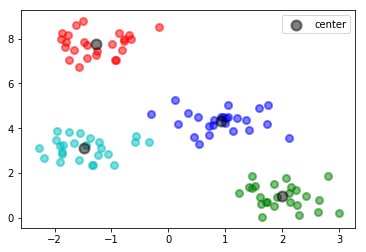

In [9]:
colorlist = ["r", "g", "b", "c", "m", "y", "w"]
for i in range(4):
    index = np.where(pred == i)
    plt.scatter(X[index,0], X[index,1], s=50, c=colorlist[i], alpha=0.5, linewidths="2")
plt.scatter(centers[:,0], centers[:,1], s=100, c="k", alpha=0.5, linewidths="2",label="center")
plt.legend()

### 【問題8】エルボー法の実装
K-meansにおいて中心点の個数 
k
 は人為的に決める必要がありますが、その判断方法としてエルボー法があります。エルボー法により中心点の個数 
k
 を検討するためのコードを作成してください。


SSEを縦軸、クラスタ数 
k
 を横軸にした折れ線グラフを表示します。このためにK-meansのインスタンスからはSSEを取得できるようにしてください。



Text(0, 0.5, 'SSE')

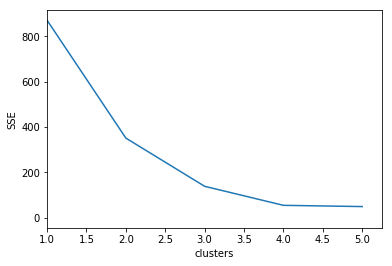

In [11]:
erbor = ScratchKMeans_erbor(X, n_clusters=5, n_init=6, max_iter=200, tol=0.1, verbose=True)
sses = erbor.min_sse_clusters
sses.insert(0, 0)
plt.plot(sses)
plt.xlim(1,)
plt.xlabel("clusters")
plt.ylabel("SSE")

### 【問題9】（アドバンス課題）シルエット図
k
 を決める助けになるものとしてシルエット図もあります。シルエット図を表示するコードを作成してください。


Matplotlibを使い図を表示するコードは用意しました。以下を与えてください。


silhouette_vals : shape(n_samples,)のndarray、各データ点のシルエット係数


silhouette_avg : float、シルエット係数の平均値


y_km : shape(n_samples,)のndarray、各データ点のクラスタラベル名


cluster_labels : list、クラスタのラベル名のリスト


n_clusters : int、クラスタ数


n
 番目のデータ点に対するシルエット係数 
s
n
 は以下の数式でを求められます。この数式を実装し、シルエット図を確認してください。
 
$$
s_n = \frac{b_n-a_n}{max(b_n,a_n)}
$$

乖離度 
b
 が大きく、凝集度 
a
 が小さい時が理想的であり、シルエット係数 
s
 は1に近くなります。

In [12]:
# 初期値設定
cluster_labels = list(set(pred))
a = np.zeros_like(pred)
b = np.zeros_like(pred)
silhouette_vals = np.zeros_like(pred)
# サンプル毎のインデックス
n = 0

# シルエット係数の計算
# クラス毎にfor
for label in cluster_labels:
    # データ毎にfor
    for i in range(X[pred==label].shape[0]):
        # aの計算
        a[n] = np.linalg.norm(X[pred==label] - X[pred==label][i], axis=1).mean()
        
        # bの計算
        # 他クラスデータとの距離を全て算出
        b_all = np.linalg.norm(X[pred!=label] - X[pred==label][i], axis=1)
        # 他クラスとの距離の平均を算出
        b_means = [b_all[pred[pred!=label]==L].mean() for L in cluster_labels if L!=label]
        # 平均の中で最小を選択
        b[n] = min(b_means)
        
        # インデックスを更新
        n +=1

# シルエット係数を求める
ab_max = np.max(np.concatenate([a[:, np.newaxis], b[:, np.newaxis]], axis=1), axis=1)
silhouette_vals = (b - a)/ab_max

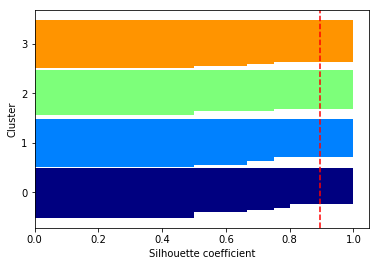

In [13]:
from matplotlib import cm
# グラフ化
silhouette_avg = silhouette_vals.mean()
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[pred == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / len(cluster_labels))
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()


### 卸売業者のデータ分析
クラスタリングを利用法を学ぶために、Wholesale customers Data Setを使用します。


UCI Machine Learning Repository: Wholesale customers Data Set


Data Folderの中からWholesale customers data.csvをダウンロードしてください。これはポルトガルのリスボンにある卸売業者（wholesale）が顧客から集めたデータです。中身は各顧客が年間でミルクや食料品を何ユーロ購入しているかというデータになっています。顧客は小売店やレストランです。RegionとChannelは取り覗き、金額のデータでK-meansを利用します。



In [14]:
data = pd.read_csv("Wholesale customers data (5).csv")
data = data.drop(columns=["Region","Channel"])
data

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...
435,29703,12051,16027,13135,182,2204
436,39228,1431,764,4510,93,2346
437,14531,15488,30243,437,14841,1867
438,10290,1981,2232,1038,168,2125


### 次元削減
金額に関する特徴量は6個ありますが、可視化するために次元削減を行います。これに関してはscikit-learnによるPCAのサンプルコードを用意したので利用してください。

In [15]:
# PCAのサンプルコード
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(data)
data_pca = pca.transform(data)
data_pca

array([[ 6.50022122e+02,  1.58551909e+03],
       [-4.42680498e+03,  4.04245151e+03],
       [-4.84199871e+03,  2.57876218e+03],
       [ 9.90346437e+02, -6.27980600e+03],
       [ 1.06579987e+04, -2.15972582e+03],
       [-2.76596159e+03, -9.59870727e+02],
       [-7.15550892e+02, -2.01300227e+03],
       [-4.47458367e+03,  1.42949697e+03],
       [-6.71209540e+03, -2.20590916e+03],
       [-4.82363435e+03,  1.34805592e+04],
       [-7.97482898e+03,  5.71121893e+03],
       [ 3.63937790e+01, -6.03789641e+03],
       [ 1.99402021e+04,  4.59128648e+03],
       [ 9.39669558e+03,  5.91315704e+03],
       [ 1.26603704e+04,  4.54194543e+03],
       [-2.99772590e+03, -6.09387930e+03],
       [-1.05895236e+04,  6.58421594e+03],
       [-6.36709518e+03, -3.68071267e+03],
       [ 6.62382534e+03,  1.25471953e+03],
       [-4.86153157e+03, -2.25592266e+02],
       [ 4.79424416e+03, -3.98879936e+03],
       [-7.24486684e+03, -7.34772325e+03],
       [ 1.92992657e+04, -6.93681068e+03],
       [ 1.

[0.45961362 0.86478588 0.93481597 0.97883941 0.99386152 1.        ]


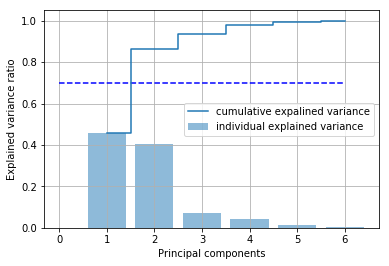

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=None)
pca = pca.fit(data)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(1,7),var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7),cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

In [17]:
# 各主成分に対する各特徴量の寄与率
# 下記の第一行目が第一主成分、列が各特徴量の寄与率
pca.components_

array([[ 0.97653685,  0.12118407,  0.06154039,  0.15236462, -0.00705417,
         0.06810471],
       [-0.11061386,  0.51580216,  0.76460638, -0.01872345,  0.36535076,
         0.05707921],
       [-0.17855726,  0.50988675, -0.27578088,  0.71420037, -0.20440987,
         0.28321747],
       [ 0.04187648,  0.64564047, -0.37546049, -0.64629232, -0.14938013,
         0.02039579],
       [-0.015986  , -0.20323566,  0.1602915 , -0.22018612, -0.20793016,
         0.91707659],
       [-0.01576316,  0.03349187,  0.41093894, -0.01328898, -0.87128428,
        -0.26541687]])

### 【問題10】クラスタ数kの選択
最適だと思われるクラスタ数 
k
 を選択してください。エルボー法やシルエット図を活用する他、人間が後々どう利用したいのかも選択に関わってきます。選択した上で、なぜそれを選んだか説明してください。



#### クラスタ数：3

In [18]:
data_np = data.values
KMeans_model_2 = ScratchKMeans(n_clusters=3, n_init=5, max_iter=100, tol=0.1, verbose=True)
KMeans_model_2.fit(data_pca)
pred_2 = KMeans_model_2.predict(data_pca)
centers_2 = KMeans_model_2.min_center

SSE（各初期値ごと）: 
[61673205261.484024, 97615742240.60678, 72300682602.42583, 84538143858.53333, 81486000841.8476]

クラスタ中心点（各初期値ごと）:
 [array([[-3000.5234581 , 18971.28493084],
       [-3117.67498623, -4277.85489358],
       [28563.43478502, -4299.34727965]]), array([[-6219.60853874, -4136.52944286],
       [ 8799.28477889, -8605.55683412],
       [ 7513.10258504,  8139.79921275]]), array([[16447.71446293, -4658.96471792],
       [-6191.07652009, 10677.18281917],
       [-4560.14120303, -5847.10179686]]), array([[  4230.01651204,  -5835.21721905],
       [-10072.06336271,  -2012.06034671],
       [  -202.93240229,  17370.70546474]]), array([[-7012.89220947, -6704.97511496],
       [10381.10660136, -3500.06865545],
       [-6963.00168681, 10438.33860625]])]


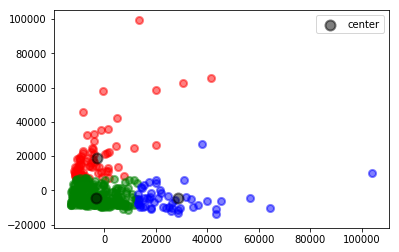

In [19]:
colorlist = ["r", "g", "b", "c", "m", "y", "w"]
for i in range(6):
    index = np.where(pred_2 == i)
    plt.scatter(data_pca[index,0], data_pca[index,1], s=50, c=colorlist[i], alpha=0.5, linewidths="2")
plt.scatter(centers_2[:,0], centers_2[:,1], s=100, c="k", alpha=0.5, linewidths="2",label="center")
plt.legend()

#### クラスタ数：4

In [20]:
data_np = data.values
KMeans_model_3 = ScratchKMeans(n_clusters=4, n_init=6, max_iter=100, tol=0.1, verbose=True)
KMeans_model_3.fit(data_pca)
pred_3 = KMeans_model_3.predict(data_pca)
centers_3 = KMeans_model_3.min_center

SSE（各初期値ごと）: 
[66119189150.86045, 66947257866.83555, 69193861612.65384, 73481068136.70738, 55811530955.86424, 61319672585.70914]

クラスタ中心点（各初期値ごと）:
 [array([[  250.78279471, -7507.2243214 ],
       [-2088.95671181, 12773.53330531],
       [18713.41766219, -4220.43512909],
       [-9420.8437224 , -2720.0049874 ]]), array([[-4683.87753226, 13893.10983233],
       [14282.57073172, -4932.64864866],
       [-5446.91371589, -6477.96076302],
       [-9294.51685296, -1987.21740393]]), array([[-7241.74270824, -6467.10533755],
       [-4185.9432989 ,   559.57913336],
       [12455.70823237, -5292.35181982],
       [-5583.69280404, 15003.09114478]]), array([[ -4537.49137497,  14610.13436797],
       [  9861.46103664,  -4932.63019325],
       [-10287.71746698,  -5810.834455  ],
       [ -5680.50432261,  -5098.67799328]]), array([[ 3954.71646797, 33656.47488069],
       [17686.52644958, -5753.77153096],
       [-8496.42124899, -1740.53869643],
       [ -147.18704644,  -804.83995962]]), array([[  182

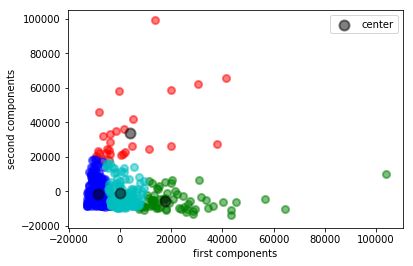

In [21]:
colorlist = ["r", "g", "b", "c", "m", "y", "w"]
for i in range(6):
    index = np.where(pred_3 == i)
    plt.scatter(data_pca[index,0], data_pca[index,1], s=50, c=colorlist[i], alpha=0.5, linewidths="2")
plt.scatter(centers_3[:,0], centers_3[:,1], s=100, c="k", alpha=0.5, linewidths="2",label="center")
plt.xlabel("first components")
plt.ylabel("second components")
plt.legend()

**ScratchKMeans_erborクラスを呼び出し、n_clusters引数を指定。このクラスタ数以下の全てのクラスタ数での結果を出力する**

Text(0, 0.5, 'SSE')

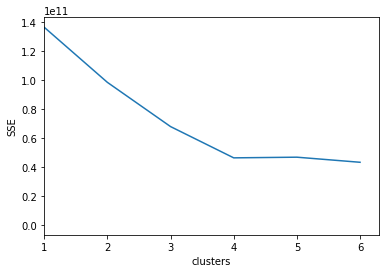

In [22]:
erbor_3 = ScratchKMeans_erbor(data_pca, n_clusters=6, n_init=6, max_iter=200, tol=0.1, verbose=True)
sses_3 = erbor_3.min_sse_clusters
sses_3.insert(0, 0)
plt.plot(sses_3)
plt.xlim(1,)
plt.xlabel("clusters")
plt.ylabel("SSE")

**今回、エルボー法からクラスター数は、3 or 4がSSEがある程度下り飽和しているため適切と考えられる。２つの場合で学習結果をグラフ化すると、クラスター数４の場合は、主成分分析の第一、第二の主成分特徴量が比較的大きいゾーンでクラスターを形成してくれており、より直感的にわかりやすいと考えられるため、今回はクラスタ数４と決定した。**

### 【問題11】既知のグループとの比較
RegionとChannelはK-meansに使用しなかったが、これれらは既知のグループです。クラスタとこれら既知のグループがどう違うかを確認し、説明してください。まずはそれぞれを可視化してください。

Text(0, 0.5, 'Channel')

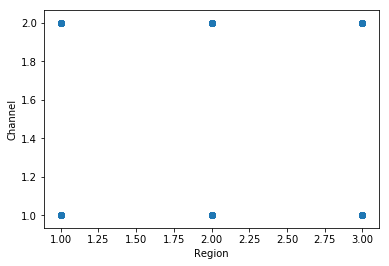

In [23]:
data_2 = pd.read_csv("Wholesale customers data (5).csv")
plt.scatter(data_2["Region"],data_2["Channel"])
plt.xlabel("Region")
plt.ylabel("Channel")

**RegionとChannelはそれぞれ１〜３、１〜２で全ての組み合わせで６通りある。**

In [24]:
# 上記の組み合わせ６通りを下記の通りクラスに分類
index_11 = np.where((data_2["Region"]==1) & (data_2["Channel"]==1))
index_21 = np.where((data_2["Region"]==2) & (data_2["Channel"]==1))
index_31 = np.where((data_2["Region"]==3) & (data_2["Channel"]==1))
index_12 = np.where((data_2["Region"]==1) & (data_2["Channel"]==2))
index_22 = np.where((data_2["Region"]==2) & (data_2["Channel"]==2))
index_32 = np.where((data_2["Region"]==3) & (data_2["Channel"]==2))

y_class = np.zeros((len(data_2)))
y_class[index_11] = 0
y_class[index_21] = 1
y_class[index_31] = 2
y_class[index_12] = 3
y_class[index_22] = 4
y_class[index_32] = 5

No handles with labels found to put in legend.


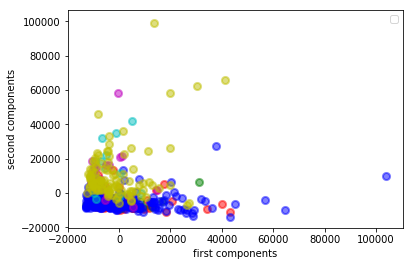

In [25]:
# RegionとChannelの６通りで分類した結果を表示
colorlist = ["r", "g", "b", "c", "m", "y", "w"]
for i in range(6):
    index = np.where(y_class == i)
    plt.scatter(data_pca[index,0], data_pca[index,1], s=50, c=colorlist[i], alpha=0.5, linewidths="2")
plt.xlabel("first components")
plt.ylabel("second components")
plt.legend()

**上記の通り、RegionとChannelによる６通りの分類では、スクラッチでの分類と違い、クラス同士でエリアが被っているところもあり、うまくクラスタに分類できていない。、また、クラス数も無駄に多いことが見て取れる。**

### 【問題12】卸売業者にとって有益な情報
卸売業者にとって有益な情報を探し出し文章にまとめてください。


《ヒント》


前処理を行う前のデータを使い、各クラスタの要約統計量を見るなどしてみましょう。また、PCAで次元削減したデータに対してK-meansを使用しましたが、6個の特徴量をそのまま使ったり、一部の特徴量のみを使ったりということも試してみてください。既知のグループとの比較結果も参考にしてください。


条件ごとにデータを見る際にはPandasのgroupbyが便利です。

                        Fresh          Milk       Grocery        Frozen  \
clusters                                                                  
0        count      29.000000     29.000000     29.000000     29.000000   
         mean    11478.758621  24268.620690  33532.827586   3324.689655   
         std     11786.196065  15259.588123  16572.206235   6687.405963   
         min        85.000000   4980.000000  17645.000000     36.000000   
         25%      4098.000000  14641.000000  23596.000000    869.000000   
         50%      6134.000000  20959.000000  28540.000000   1456.000000   
         75%     14531.000000  28326.000000  34792.000000   3254.000000   
         max     44466.000000  73498.000000  92780.000000  36534.000000   
1        count      68.000000     68.000000     68.000000     68.000000   
         mean    33997.044118   4886.852941   5470.264706   5805.985294   
         std     15140.544785   4886.240704   4280.661958   8281.096507   
         min     20105.00

Text(0.5, 1.0, 'mean')

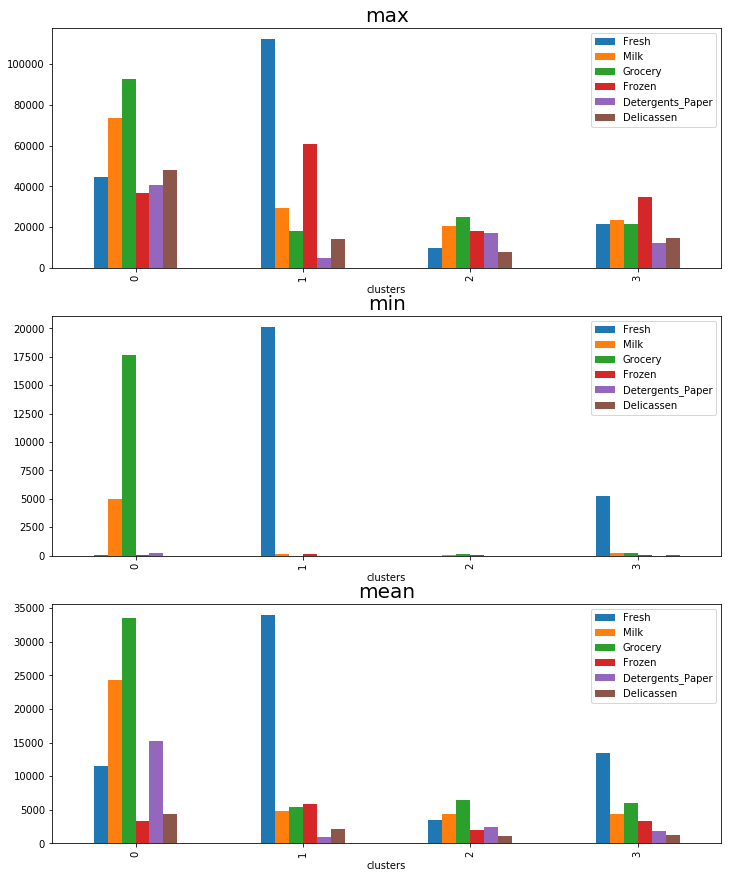

In [26]:
data_4 = pd.read_csv("Wholesale customers data (5).csv")
data_4 = data_4.drop(columns=(["Channel","Region"]))
data_4["clusters"] = pred_3   # スクラッチで予想したクラスタを結合する
fig, ax = plt.subplots(3, 1, figsize=(12, 15))
fig.patch.set_facecolor('white')
print(data_4.groupby("clusters").describe().stack())
data_4.groupby("clusters").max().plot.bar(ax=ax[0])
ax[0].set_title('max',fontsize=20)
data_4.groupby("clusters").min().plot.bar(ax=ax[1])
ax[1].set_title('min',fontsize=20)
data_4.groupby("clusters").mean().plot.bar(ax=ax[2])
ax[2].set_title('mean',fontsize=20)

In [27]:
# 各主成分に対する各特徴量の寄与率
# 下記の第一行目が第一主成分、列が各特徴量の寄与率
pca.components_

array([[ 0.97653685,  0.12118407,  0.06154039,  0.15236462, -0.00705417,
         0.06810471],
       [-0.11061386,  0.51580216,  0.76460638, -0.01872345,  0.36535076,
         0.05707921],
       [-0.17855726,  0.50988675, -0.27578088,  0.71420037, -0.20440987,
         0.28321747],
       [ 0.04187648,  0.64564047, -0.37546049, -0.64629232, -0.14938013,
         0.02039579],
       [-0.015986  , -0.20323566,  0.1602915 , -0.22018612, -0.20793016,
         0.91707659],
       [-0.01576316,  0.03349187,  0.41093894, -0.01328898, -0.87128428,
        -0.26541687]])

主成分の寄与率より、第一主成分は特徴量[0]:Fresh,　第二主成分は特徴量[2]:Groceryが高い事がわかる。クラスタ別の各統計量でもFresh、Groceryの特徴量で大きな差がある事がわかる。よって、卸売業者はこれらの特徴量に着目する事が良いと考えられる。

### 【問題13】（アドバンス課題）他の手法の調査
今回扱ったK-means以外に非階層クラスタリングで有名な手法としては DBSCAN 、
PCA以外に次元削減手法で有名な手法としては t-SNE や LLE があります。


DBSCANのメリット・デメリット
t-SNE、LLEのメリット・デメリット

について記述してください。

●DBSCAN
　
 
 ・メリット

k-meansと異なり最初にクラスタ数を決めなくて良い。
クラスタが球状であることを前提としていない。
外れ値に対しロバスト。
　
 
 ・デメリット

border点の概念が微妙で，データによりどのクラスタに属するか変わる可能性がある。
距離の計算方法により，精度が変わる。
ハイパーパラメータ調整が困難。特にデータが密集していると難しい。

●t-SNE
　
 
 ・メリット

非線形な関係を捉えることができる。
高次元データを次元圧縮し可視化することができる。
高次元空間上の類似度を低次元空間に表現することができる
　
 
 ・デメリット

うまくいくことが保証されているのは2or3次元への圧縮のみ。
局所構造が次元の呪いの影響を受けやすい。
最適化アルゴリズムの収束性が保証されていない。

●LLE

　
 ・メリット

非線形にも対応できる
高次元データも対応可能
　
 
 ・デメリット

データがひとまとまりになっていないと構造を捉えることができない

### 【問題14】（アドバンス課題）t-SNEとDBSCANの利用
Wholesale customersのデータに対して、PCAではなく、 t-SNE を用いて次元削減をしてください。さらにK-meansではなく、 DBSCAN を用いてクラスタリングしてください。


そのクラスタリング結果をPCA+kmeansの場合の結果と比較してみましょう。実装にはscikit-learnを用いてください。

これらはK-meansやPCAに比べパラメーターチューニングが難しい手法です。scikit-learnのドキュメントと共に論文も参考にしながらパラメータの意味を確認することも大切になります。


In [36]:
from sklearn.manifold import TSNE

data_6 = pd.read_csv("Wholesale customers data (5).csv")
data_6 = data_6.drop(columns=["Region","Channel"])
data_6 = data_6.values

TSNE = TSNE(n_components = 2, perplexity=30)
data_TSNE = TSNE.fit_transform(data_6)

In [37]:
# DBSCAN
from sklearn.cluster import DBSCAN
DBSCAN = DBSCAN(eps=2.2, min_samples=4)
pred_DBSCAN = DBSCAN.fit_predict(data_TSNE)
pred_DBSCAN

array([ 0,  1,  1,  3,  4,  0,  0,  1,  2,  1,  1,  3,  4,  4,  4,  3,  1,
        2,  4,  1,  4,  3,  3, -1,  4,  4,  3,  3,  1,  3,  4,  3,  3,  3,
        3,  1,  3,  6,  1,  3,  5,  4,  6,  1,  7,  1,  1,  8,  7,  1,  3,
        1,  3,  1,  3,  2,  1,  1,  3,  1,  1,  8,  1,  6,  3,  1,  1,  4,
        3,  3,  9,  4,  3,  5,  1,  3,  3,  1,  3,  3,  3,  1,  7,  3,  0,
        8,  8,  3,  3,  3,  3,  3,  1,  3,  1,  3,  1,  3,  3,  3,  6,  1,
        1,  3,  3,  3,  1,  6,  1,  1,  3,  6,  9,  3,  3,  3, -1,  2,  3,
        3,  3,  3,  3,  0,  3,  3,  9,  4, 10,  3,  3,  3,  3,  3,  3,  3,
        1,  1,  0,  2,  4,  4,  3,  3,  3,  1,  3,  3,  3,  3,  3,  3,  3,
       10,  3,  1,  1,  3,  1,  1,  1,  3,  3,  1,  1,  6,  1,  3,  3,  3,
        1,  1,  1,  1,  3,  1,  3,  0,  0,  3,  0,  3,  1, -1,  3,  3,  3,
        1,  7,  1,  9,  3,  3,  1,  3,  9,  5,  1, 11,  3,  1,  1,  4,  3,
        3,  1,  3,  1,  1,  1,  3,  1,  3,  1,  1,  1,  1,  3,  1,  3,  3,
        1,  3,  3,  3,  0

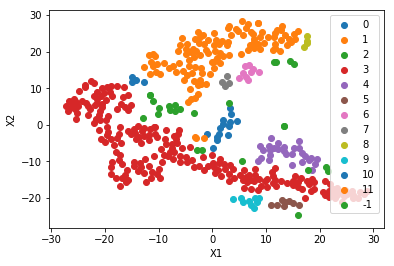

In [38]:
# グラフ化
for n in set(pred_DBSCAN):
    plt.scatter(data_TSNE[pred_DBSCAN==n][:, 0],
                data_TSNE[pred_DBSCAN==n][:, 1], label=n)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()

TSNEは、”n_components”で次元数、 ”perplexity”で複雑性をパラメータで指定できる。n_components=2,perplexity=30で実施した上記のグラフでは、X１,X２の２要素で各データ点が散らばり、元の情報量をあまり失わずに、この２つの要素でデータを表す事ができていそうである。
また、DBSCANは,
eps:一方が他方の近傍と見なされる2つのサンプル間の最大距離
    
min_samples：コアポイントと見なされるポイントの近傍内のサンプル数
の２つを設定する必要があり、データが密集していると適切にεとminPtsを決めるのが難しいという特徴がある。しかし、適切に設定する事で　kmean のように円でなく形が柔軟なクラスタで分けることも可能となる。
また、クラスタの扱いではない（単体のノイズ扱い）場合は、マイナスでラベルされる。